<h1>Question 3: EM Algorithm & Implementation</h1>

<p> Sources used to understand and describe the explanation include: 
    https://cs.nyu.edu/courses/fall11/CSCI-GA.2271-001/K-means.EM.pdf, 
    https://stats.stackexchange.com/questions/117874/k-means-as-a-limit-case-of-em-algorithm-for-gaussian-mixtures-with-covariances </p>

<h2>Part A: Show that K-means is a special case of the EM Algorithm </h2>

<p> The major difference between K-Means and the EM algorithm is 'hard assignment' vs 'soft assignment'. In k-means,
    at every step of the process i.e. iteration we are certain of which cluster a point belongs to. This is the hard
    assignment. On the other hand, for the EM algorithm, at every iteration we have a level of uncertainty e.g. 70%
    certain a point is in a certain cluster. However, since there is a degree of uncertainty, this is a 'soft assignment'. In a way, we can think of mixture models as generalizing K-Means by also incorporating information
about the covariance matrices</p>
    
<p> The K-Means method can be interpreted as the EM method with the E-Step integral in x replaced by the considering the term that maximizes log probability of x given a hard assignment of a cluster i.e. the term with the best assignment of the observed data given the current estimate of the cluster. </p>

<h3> See write up for objective function of E-Step and M-Step </h3>

<h2>Part B: Download, Parse and Plot Data</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Use the loadtxt function of Numpy and specify paramters for skiprows and usecol to extract relevant data
#into numpy array 
data = np.loadtxt('faithful.dat', skiprows=26, usecols = (1,2))

x = data[:,0]
y = data[:,1]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(x,y)
plt.title("Plotting All Data Points on the 2D Plane")
plt.xlabel("Eruption Time in Minutes")
plt.ylabel("Waiting Time to Next Eruption")
plt.show

<function matplotlib.pyplot.show>

<h2>Part C: Implementing a Bimodal GMM to Fit All Data Points </h2>

<h3> As a point of reference, we first used the sklearn.mixtures package function for GMM</h3>

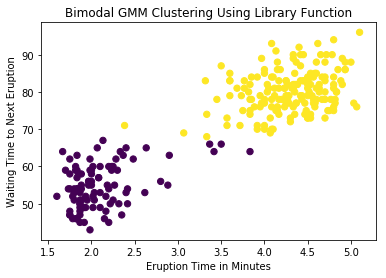

In [2]:
from sklearn.mixture import GaussianMixture

gmCheck = GaussianMixture(n_components=2, covariance_type='spherical', init_params='random')
gmCheck.fit(data)

labels = gmCheck.predict(data)

plt.title("Bimodal GMM Clustering Using Library Function")
plt.xlabel("Eruption Time in Minutes")
plt.ylabel("Waiting Time to Next Eruption")
plt.scatter(data[:, 0], data[:, 1], c=labels, s=40);

<h3>Full Implementation</h3>

In [3]:
#Note: For the full implementation of the GMM, we referenced the scribe notes from class and primarily used 
##an open-source implementation of the GMM from GitHub with minor modifications
#Source: https://gist.github.com/bistaumanga/6023716 

import random

mu1_trajectory = []
mu2_trajectory = []
mu1K_trajectory = []
mu2K_trajectory = []

class GMM:
    
    #function to initialize new Gaussian mixture model
    def __init__(self, k = 2, eps = 0.0001, setInitial= False, initialMu = [], initialSigma=[]):
        self.k = k ## number of clusters, set to 2 by default since we are looking for a bimodal implementation
        self.eps = eps ## threshold to stop `epsilon`
        self.setInitial = setInitial ##describes if initial paramaters have been provided, set to false by default
        self.initialMu = initialMu
        self.initialSigma = initialSigma
    
    #EM Algorithm implementation for fitting
    ## Note: Maximum number of iterations defined in method
    def fit_EM(self, X, max_iters = 1000):
        
        iterationCount = 1
        
        # n = number of data-points, d = dimension of data points        
        n, d = X.shape
        
        # randomly choose the starting centroids/means as 2 data points using the random choice function of numpy
        ## as 2 of the points from datasets
        if(self.setInitial != True):
            mu = X[np.random.choice(n, self.k, False), :]
        else:
            mu = self.initialMu
        #print 'Initial Mu'
        #print mu.shape
        #print mu
        
        temp1 = mu[0]
        temp2 = mu[1]
        
        if(self.setInitial != True):
            mu1_trajectory.extend(temp1)
            mu2_trajectory.extend(temp2)
        else:
            mu1K_trajectory.extend(temp1)
            mu2K_trajectory.extend(temp2)
        
        # initialize the covariance matrices for each gaussian
        if(self.setInitial != True):
            randomScalar = random.randint(1,100)
            Sigma= [np.eye(d) * randomScalar] * self.k
        else:
            Sigma = self.initialSigma
            
        #print ("Printing Sigma")
        #print Sigma
        
        # initialize the probabilities/weights for each gaussians as 1/number of clusters
        w = [1./self.k] * self.k
        
        # responsibility matrix is initialized to all zeros
        # we have responsibility for each of n points for eack of k gaussians
        R = np.zeros((n, self.k))
        
        ### log_likelihoods
        log_likelihoods = []
        
        P = lambda mu, s: np.linalg.det(s) ** -.5 ** (2 * np.pi) ** (-X.shape[1]/2.) \
                * np.exp(-.5 * np.einsum('ij, ij -> i',\
                        X - mu, np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 
                        
        # Iterate till max_iters iterations or until convergence        
        while len(log_likelihoods) < max_iters:
            
            #print iterationCount
            # E - Step
            
            ## Vectorized implementation of e-step equation to calculate the 
            ## membership for each of k -gaussians
            for k in range(self.k):
                R[:, k] = w[k] * P(mu[k], Sigma[k])

            ### Likelihood computation
            log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
            
            log_likelihoods.append(log_likelihood)
            
            ## Normalize so that the responsibility matrix is row stochastic
            R = (R.T / np.sum(R, axis = 1)).T
            
            ## The number of datapoints belonging to each gaussian            
            N_ks = np.sum(R, axis = 0)
            
            
            # M Step
            ## calculate the new mean and covariance for each gaussian by 
            ## utilizing the new responsibilities
            for k in range(self.k):
                
                ## means
                mu[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
                x_mu = np.matrix(X - mu[k])
                #print mu[0]
                #print mu[1]
                
                #add new means to the trajectory lists

                   
                ## covariances
                Sigma[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))
                
                ## and finally the probabilities
                w[k] = 1. / n * N_ks[k]
            
            iterationCount +=1
            temp1 = mu[0]
            temp2 = mu[1]
        
            if(self.setInitial != True):
                mu1_trajectory.extend(temp1)
                mu2_trajectory.extend(temp2)
            else:
                mu1K_trajectory.extend(temp1)
                mu2K_trajectory.extend(temp2)
                
            # check for convergence
            if len(log_likelihoods) < 2 : continue
            if np.abs(log_likelihood - log_likelihoods[-2]) < self.eps: break
        
        #print "Iterations completed"
        
        #print "Final Version of Mean List 1 = "
        #print mu1_trajectory
        
        ## bind all results together
        from collections import namedtuple
        self.params = namedtuple('params', ['mu', 'Sigma', 'w', 'log_likelihoods', 'num_iters'])
        self.params.mu = mu
        self.params.Sigma = Sigma
        self.params.w = w
        self.params.log_likelihoods = log_likelihoods
        self.params.num_iters = len(log_likelihoods)       
        
        return self.params
    
    def plot_log_likelihood(self):
        import pylab as plt
        plt.plot(self.params.log_likelihoods)
        plt.title('Log Likelihood vs iteration plot')
        plt.xlabel('Iterations')
        plt.ylabel('log likelihood')
        plt.show()
    
    def predict(self, x):
        p = lambda mu, s : np.linalg.det(s) ** - 0.5 * (2 * np.pi) **\
                (-len(x)/2) * np.exp( -0.5 * np.dot(x - mu , \
                        np.dot(np.linalg.inv(s) , x - mu)))
        probs = np.array([w * p(mu, s) for mu, s, w in \
            zip(self.params.mu, self.params.Sigma, self.params.w)])
        return probs/np.sum(probs)

<h3>Testing & Visualization: Plotting Results & Trajectory of Mean Vectors</h3>

9
(10, 2)
(10, 2)


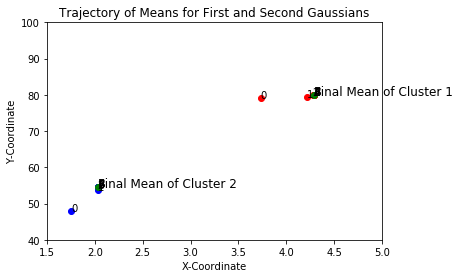

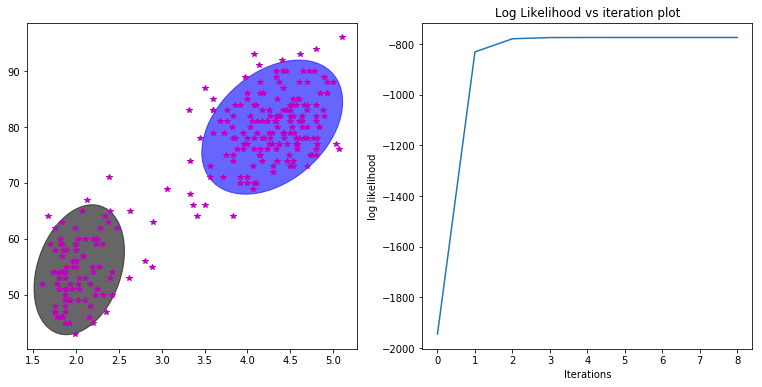

In [4]:
#Source: https://gist.github.com/bistaumanga/6023716 

gmm1 = GMM(2, 0.001)
params = gmm1.fit_EM(data, max_iters= 100)
print gmm1.params.num_iters

#create and print trajectory of mean vector for first Gaussian
meanSet1 = []
meanSet2 = []

#print mu1_trajectory
i=0
while i < len(mu1_trajectory):
    x1 = mu1_trajectory[i]
    y1 = mu1_trajectory[i+1]
    tempPoint1 = [x1,y1]
    meanSet1.append(tempPoint1)
    
    x2 = mu2_trajectory[i]
    y2 = mu2_trajectory[i+1]
    tempPoint2 = [x2,y2]
    meanSet2.append(tempPoint2)
    
    i = i+2
    
plt.title("Trajectory of Means for First and Second Gaussians")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")


meanSet1 = np.array(meanSet1)
meanSet2 = np.array(meanSet2)

print meanSet1.shape
print meanSet2.shape

for i in range(meanSet1.shape[0]):
    plt.xlim(right=5.0)
    plt.xlim(left=1.5)
    plt.ylim(top=100)
    plt.ylim(bottom=40)
    if(i == meanSet1.shape[0] - 1):
        plt.plot(meanSet1[i,0], meanSet1[i,1], 'g-o')
        plt.text(meanSet1[i,0], meanSet1[i,1], 'Final Mean of Cluster 1', fontsize=12)
        plt.plot(meanSet2[i,0], meanSet2[i,1], 'g-o')
        plt.text(meanSet2[i,0], meanSet2[i,1], 'Final Mean of Cluster 2', fontsize=12)
    else:
        plt.plot(meanSet1[i,0], meanSet1[i,1], 'r-o')
        plt.text(meanSet1[i,0], meanSet1[i,1], i, fontsize=10)
        plt.plot(meanSet2[i,0], meanSet2[i,1], 'b-o')
        plt.text(meanSet2[i,0], meanSet2[i,1], i, fontsize=10)

#plt.scatter(meanSet1[:, 0], meanSet2[:, 1], );


#print params.log_likelihoods

import pylab as plt    
from matplotlib.patches import Ellipse

#function to plot clusters from bimodal Gaussian
def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    
    if ax is None:
        ax = plt.gca()
    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
    ax.add_artist(ellip)
    return ellip    

#additional function for visualization
def show(X, mu, cov):

    plt.cla()
    K = len(mu) # number of clusters
    colors = ['b', 'k', 'g', 'c', 'm', 'y', 'r']
    plt.plot(X.T[0], X.T[1], 'm*')
    for k in range(K):
        plot_ellipse(mu[k], cov[k],  alpha=0.6, color = colors[k % len(colors)])  

    
fig = plt.figure(figsize = (13, 6))
fig.add_subplot(121)
show(data, params.mu, params.Sigma)
fig.add_subplot(122)

#plotting log likelihoods vs iterations
plt.plot(np.array(params.log_likelihoods))
plt.title('Log Likelihood vs iteration plot')
plt.xlabel('Iterations')
plt.ylabel('log likelihood')
plt.show()
#print gmm1.predict(np.array([1, 2]))

<h3>Running Program 50 Times and Plotting Distribution of Number of Iterations</h3>

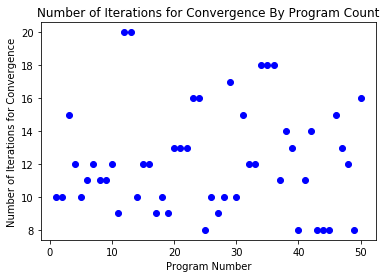

In [5]:
iterationCount = []

for i in range(50):
    gmmTest = GMM(2, 0.001)
    params = gmmTest.fit_EM(data, max_iters= 100)
    itCount = gmmTest.params.num_iters
    tempPoint = [i+1, itCount]
    iterationCount.append(tempPoint)

plt.title('Number of Iterations for Convergence By Program Count')
plt.xlabel('Program Number')
plt.ylabel('Number of Iterations for Convergence')

iterationCount = np.array(iterationCount)

for i in range(iterationCount.shape[0]):
    plt.plot(iterationCount[i,0], iterationCount[i,1], 'b-o')

<h2> Part D: Initializing Parameters via K-Means and MLE </h2>

[[ 4.29793023 80.28488372]
 [ 2.09433    54.75      ]]


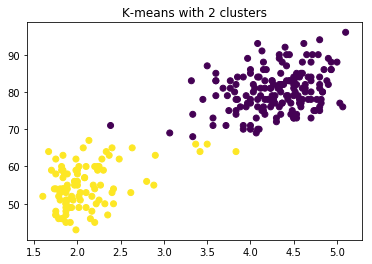

In [6]:
#used library class sklearn.cluster.kmeans to conduct clustering with k-means
#Source: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
import pylab as pl

#Ran k-means algorithm over data points with k=2
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

#print kmeans.labels_
print kmeans.cluster_centers_

#Plot scatter plot with k-means clusters
pl.title('K-means with 2 clusters')
pl.scatter(data[:, 0], data[:, 1], c=kmeans.labels_)
pl.show()

In [7]:
# the first guesses of the means in these cases will simply be the cluster centers from k-means
mean1_guess = kmeans.cluster_centers_[0]
mean2_guess = kmeans.cluster_centers_[1]

print mean1_guess
print mean2_guess

[ 4.29793023 80.28488372]
[ 2.09433 54.75   ]


In [8]:
#Setting initial guesses of covariance matrices from k-means clusters

#creating two, 2-d arrays for the two clusters created from k-means

cluster1 = []
cluster2 = []

#filling up arrays for clusters based on labels generated from k-means
for i in range (len(data)):
    if kmeans.labels_[i] == 0:
        cluster1.append(data[i])
    else:
        cluster2.append(data[i])    

#transposing cluster matrices for use in np.cov function
cluster1 = np.transpose(cluster1)
cluster2 = np.transpose(cluster2)

#creating covariance matrices from transposed cluster matrices
cov_cluster1 = np.cov(cluster1)
cov_cluster2 = np.cov(cluster2)


#printing covariance matrices for reference checking
print cov_cluster1
print cov_cluster2

[[ 0.17865587  0.76756385]
 [ 0.76756385 31.66690466]]
[[ 0.15583707  0.99561869]
 [ 0.99561869 34.75505051]]


<h3>Running GMM with Initial Guesses from K-Means Output </h3>

[array([[ 0.17865587,  0.76756385],
       [ 0.76756385, 31.66690466]]), array([[ 0.15583707,  0.99561869],
       [ 0.99561869, 34.75505051]])]
[array([ 4.29793023, 80.28488372]), array([ 2.09433, 54.75   ])]


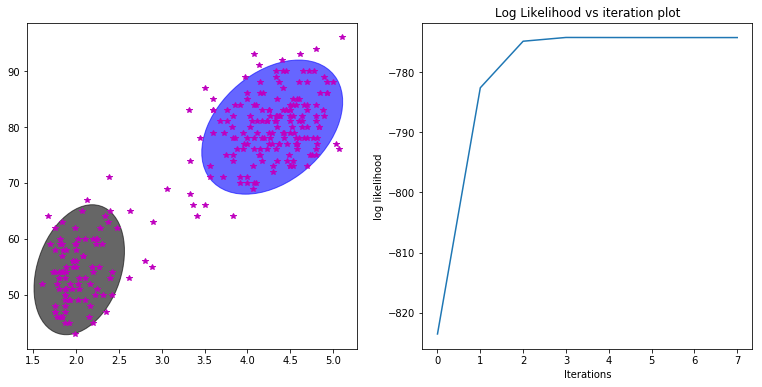

(368, 2)
(368, 2)


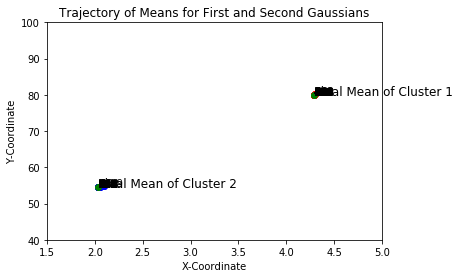

In [21]:
#setting initialSigma to covariance matrices of clusters generated from K-means
initialSigma = [cov_cluster1, cov_cluster2]
print initialSigma

#setting initial means of gaussians to the means of the labeled data from K-means
initialMu = [mean1_guess,mean2_guess]
print initialMu

#running GMM with EM algorithm with initial paramaters set from K-means
gmm_withK = GMM(2, 0.001, True, initialMu, initialSigma)
params_withK = gmm_withK.fit_EM(data, max_iters= 100)
#print gmm_withK.params.num_iters

fig = plt.figure(figsize = (13, 6))
fig.add_subplot(121)
show(data, gmm_withK.params.mu, gmm_withK.params.Sigma)
fig.add_subplot(122)

plt.plot(np.array(gmm_withK.params.log_likelihoods))
plt.title('Log Likelihood vs iteration plot')
plt.xlabel('Iterations')
plt.ylabel('log likelihood')
plt.show()

#printing trajector of Mean Vectors

meanSet1K = []
meanSet2K = []

#print trajectory of means for both gaussians
i=0
while i < len(mu1K_trajectory):
    x1 = mu1K_trajectory[i]
    y1 = mu1K_trajectory[i+1]
    tempPoint1 = [x1,y1]
    meanSet1K.append(tempPoint1)
    
    x2 = mu2K_trajectory[i]
    y2 = mu2K_trajectory[i+1]
    tempPoint2 = [x2,y2]
    meanSet2K.append(tempPoint2)
    
    i = i+2
    
plt.title("Trajectory of Means for First and Second Gaussians")
plt.xlabel("X-Coordinate")
plt.ylabel("Y-Coordinate")


meanSet1K = np.array(meanSet1K)
meanSet2K = np.array(meanSet2K)

print meanSet1K.shape
print meanSet2K.shape

for i in range(meanSet1K.shape[0]):
    plt.xlim(right=5.0)
    plt.xlim(left=1.5)
    plt.ylim(top=100)
    plt.ylim(bottom=40)
    if(i == meanSet1K.shape[0] - 1):
        plt.plot(meanSet1K[i,0], meanSet1K[i,1], 'g-o')
        plt.text(meanSet1K[i,0], meanSet1K[i,1], 'Final Mean of Cluster 1', fontsize=12)
        plt.plot(meanSet2K[i,0], meanSet2K[i,1], 'g-o')
        plt.text(meanSet2K[i,0], meanSet2K[i,1], 'Final Mean of Cluster 2', fontsize=12)
    else:
        plt.plot(meanSet1K[i,0], meanSet1K[i,1], 'r-o')
        plt.text(meanSet1K[i,0], meanSet1K[i,1], i, fontsize=10)
        plt.plot(meanSet2K[i,0], meanSet2K[i,1], 'b-o')
        plt.text(meanSet2K[i,0], meanSet2K[i,1], i, fontsize=10)


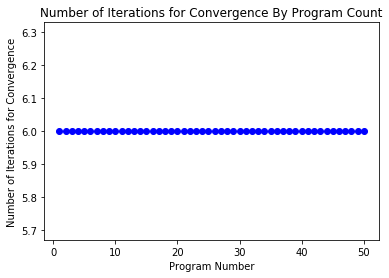

In [22]:
#Running program 50 times with initial parameters set by results of K-Means
## Store value of number of iterations for each program in an array of Iteration Counts
iterationCount_k = []

for i in range(50):
    gmmTest_k = GMM(2, 0.001, True, initialMu, initialSigma)
    params = gmmTest_k.fit_EM(data, max_iters= 100)
    itCount = gmmTest_k.params.num_iters
    tempPoint_k = [i+1, itCount]
    iterationCount_k.append(tempPoint_k)

plt.title('Number of Iterations for Convergence By Program Count')
plt.xlabel('Program Number')
plt.ylabel('Number of Iterations for Convergence')

iterationCount_k = np.array(iterationCount_k)

#plot number of iterations required by program number
for i in range(iterationCount_k.shape[0]):
    plt.plot(iterationCount_k[i,0], iterationCount_k[i,1], 'b-o')

<h3>Comparing algorithm performance in part C vs in part D</h3>

<p>
There are 2 key differences in the results of the algorithms with an without K-Means generated initial paramaters. 

1) The number of iterations required for convergence is significantly lower i.e. 6 when K-Means generates the initial means and
covariance matrices. On the other hand, the average number of iterations required when using the EM algorithm with randomly generated initial
paramaters is much higher i.e. nearly 13 and even higher for some programs. 

2) Secondly, the trajectory of the means change significantly before convergence when the initial paramters are randomized
for the EM algorithm. On the other hand, when the initial paramaters are set using the results of K-Means, the means
do not change much before arriving at the final mean for convergence.

Both of the above make sense when we look at the impact of what we are doing in the different cases. Since K-Means
already generates a fairly strong guess of the centroids for each cluster, the number of iterations required for
convergence are much lower. Also, since the centroid/mean generated by K-Means is either the best guess for the real
mean/centroid or very close to it, we can see that the trajectory of the mean doesn't go too far before convergence i.e.
the trajectory's path isn't very expansive.

</p>

<h1>Question 4: Multidimensional Scaling for Genetic Population Differences </h1>

<h2>Part A: Use MDS to coerce D into a 2-D Vector Representation</h2>

<h3> Part A, Subpart 1: What assumptions are being made in the MDS? In what circumstances could this fail? 
How could we measure how much information is being lost? </h3>

<p> In general, MDS is a great tool for analyzing the relationships between different data points but does not provide real insight into the actual distances (or numbers) between data points. The resulting scatter plot can might also encourage this misleading assumption of the relationships signifying quantifiable numeric distances between points which can be problematic. </p>

<p> The first major assumption here is that the differences between races via the Modified Nei's distance is
actually a good representation of differences between different genetic populations. This is a potentially problematic assumption since it is highly dependent on the assumption that the allele frequencies at different locations is a strong enough measure of similarlity or dissimilarity. 
</p>

<p> The second major assumption and more problematic one is that these differences via Nei's distance can actually correlate to some form of Euclidean distances that can be captures in a 2-d format (and 2-d space) without major loss of information. One major reason this assumption may not hold is because we are trying to capture dissimilarities across all 42 data points in a reduced 2-d space. As per the positioning of data points with this method, the Japanese race is considered similar to the South-American races. HOWEVER, if we were to conduct the same embedding for a smaller set of data points e.g. 6 points instead of 42, the resulting embedding might yield a very different positioning for data points compared to each other. For example - the Japanese race might be positioned very far away in such a situation to the South-American data point altogther. </p>

<p> Conducting the same embedding and lower-dimensional scaling analysis on smaller sub-sets of the sample space might yield some insights into how much information is being lost. The analysis and embedding conducted on the entire set of 42 is not a robust measure of similarity between 2 specific points, but only useful when analyzing the entire set as a whole</p>

In [11]:
#downloaded data set from Professor Kallus' website and used sample code for loading & printing

import numpy as np
data2 = np.load("mds-population.npz")
print data2['D'] # Distance matrix
print data2['population_list'] # List of populations

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
['Bantu' 'E. Afncan' 'Nilo-Saharan' 'W. African' 'San' 'Barter' 'Mbuti'
 'Indian' 'Iranian' 'Near Eastern' 'Uralic' 'Ainu' 'Japanese' 'Korean'
 'Mon Khmer' 'Thai' 'Dravidian' 'Mongol Tungus' 'Tibetan' 'Indonesian'
 'Malaysian' 'Filipino' 'N. Turkic' 'S. Chinese' 'Basque' 'Lapp'
 'Sardinian' 'Danish' 'English' 'Greek' 'Italian' 'C Amerind' 'Eskimo'
 'Na-Dene' 'N. American' 'S. American' 'Chukchi' 'Melanesian'
 'Micronesian' 'Polynesian' 'New Guinean' 'Australian']


In [12]:
#used functions in library class sklearn.manifold to conduct embedding & transformation
#Source Link: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

from sklearn.manifold import MDS
embed = MDS(n_components=2)
d_transformed = embed.fit_transform(data2['D'])
print d_transformed.shape

/Users/anirbanpoddar/anaconda2/lib/python2.7/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(42, 2)


<h3>Part A: Subpart 2</h3>

<function matplotlib.pyplot.show>

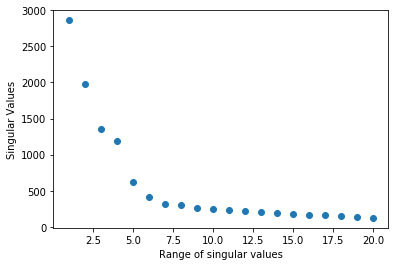

In [23]:
from scipy import linalg

mds_test = MDS(n_components=20)
D_transformedTest= mds_test.fit_transform(data2['D'])
s = linalg.svdvals(D_transformedTest)
plt.scatter(range(1,21), s)
plt.xlabel('Range of singular values')
plt.ylabel('Singular Values')
plt.show

For m = 20, we inspect the singular values and we notice an elbow plot. Based on the elbow plot we can see that most of the variation is captured in the first 8 singular values. Based on this elbow plot, we could infer that that first 8 dimensions provide most of the necessary variation in the data.

<h3> Part A: Subpart 3</h3>

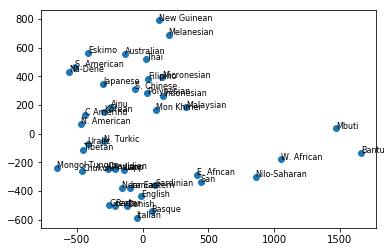

In [27]:
#After using MDS to embed distance matrix into 2 dimensions, plotted resulting scatterplot

fig2,ax1 = plt.subplots()
ax1.scatter(d_transformed[:,0], d_transformed[:,1])

for i, label in enumerate(data2['population_list']):
    ax1.annotate(label, (d_transformed[i,0], d_transformed[i,1]), fontsize = 8)

<h3>Part B: Running k-means</h3>

[0 1 0 0 1 1 0 1 1 1 3 3 3 3 2 2 1 3 3 2 2 2 3 2 1 1 1 1 1 1 1 3 3 3 3 3 3
 2 2 2 2 2]
[[1258.75961021 -145.0691449 ]
 [ -35.18371476 -397.14814942]
 [  87.46427063  412.44710958]
 [-423.42872393  123.34095893]]


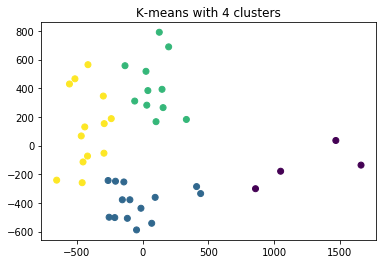

In [29]:
#used library class sklearn.cluster.kmeans to conduct clustering with k-means
#Source: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
import pylab as pl


#After several trials, set number of clusters to 4 for best results based on resulting cluster plot
kmeans = KMeans(n_clusters=4, random_state=0).fit(d_transformed)
print kmeans.labels_
print kmeans.cluster_centers_

#Plot scatter plot with k-means clusters
pl.title('K-means with 4 clusters')
pl.scatter(d_transformed[:, 0], d_transformed[:, 1], c=kmeans.labels_)
pl.show()

<p> After several rounds of trial and error, I picked 4 clusters because that seemed to provide the best 
differentiation based on a simple visual analysis of the different cluster </p>

<p> The information that seems to be lost here is the actual similarity between points that are assigned to the same
clusters. For example, the data points that are assigned to the cluster on the bottom-right of the graph plotted above,
actually have reasonably large distances between themselves. However, since we conducting the clustering based on the
relationships (in distances) between ALL 42 data points we lose the informationn on how dissimilar these points might
actually be despite being in the same cluster. With a larger number of clusters, it is possible that these points might
actually occupy different clusters </p>

<h3>Part C: Comparing Heirarchical Clustering with K-Means </h3>

/Users/anirbanpoddar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys


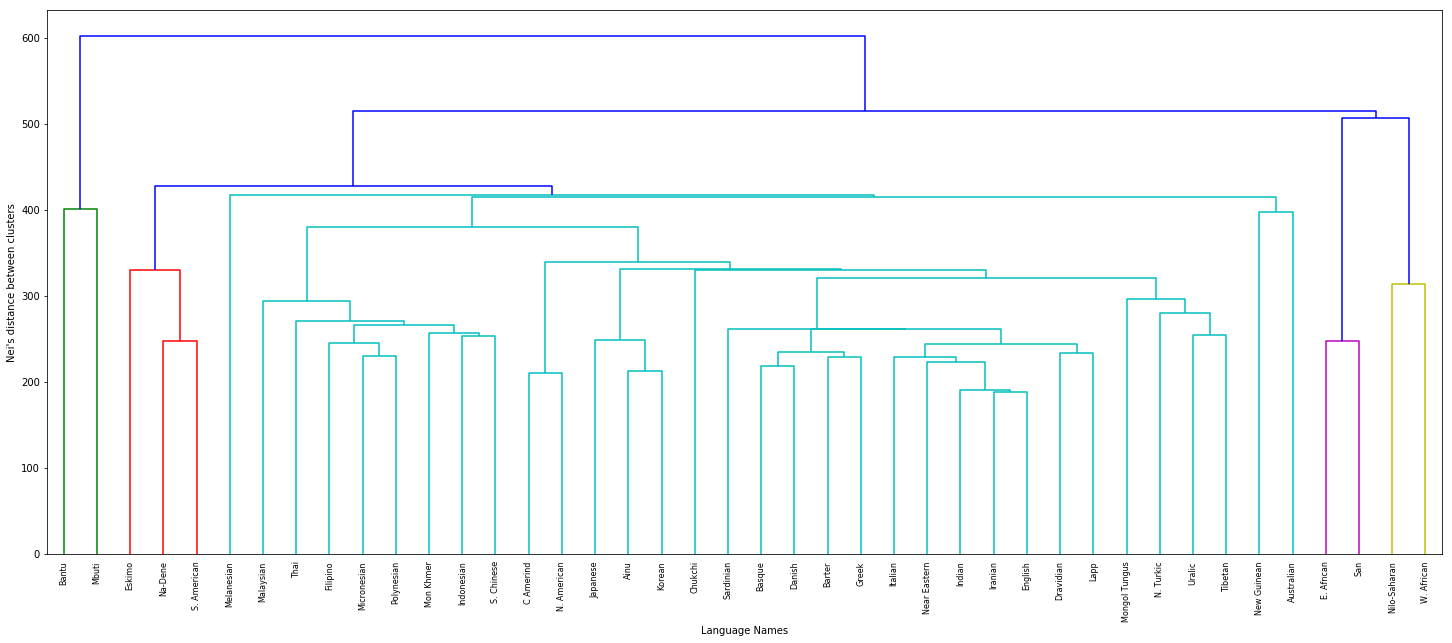

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

#Used the scipy.cluster library class for linkages and creating the dendrogram
#Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

Z = linkage(data2['D'], 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels = data2['population_list'])

plt.xlabel("Language Names")
plt.ylabel("Nei's distance between clusters")
plt.show()

In [24]:
#use fcluster function to form the clusters
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, 430, criterion='distance')
clusters

array([1, 3, 4, 4, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

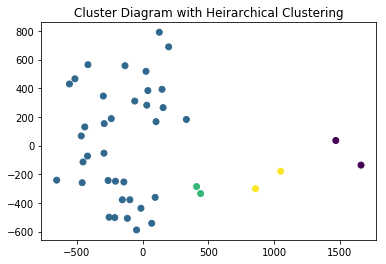

In [25]:
#plot clusters formed from heirarchical clustering and f-cluster function
pl.title('Cluster Diagram with Heirarchical Clustering')
pl.scatter(d_transformed[:, 0], d_transformed[:, 1], c=clusters)

<p> As we can see from the visual output of the clustering, the outliers occupy smaller clusters but are quite 
separated from the large cluster of data points to the left of the 2-D Space. This makes intuitive sense when
considering how the algorithm for heirarchical clustering works. </p>

<p> At each step, heirarchical clustering tries to form clusters at each step by maximizing the distance with other clusters and finding points closer together. Therefore the output we see above makes sense since despite the smaller number of data points, each of the smaller clusters are furhter away by distance from the one, large cluster to the left. </p>

<h3>Part D: Compare K-Medoids and K-Means</h3>

In [33]:
#Note: We have used a publically available implementation of k-medoids from GitHub for this section
#Source: https://github.com/letiantian/kmedoids/blob/master/kmedoids.py 


from sklearn.metrics.pairwise import pairwise_distances

def kMedoids(D, k, tmax=100):
    # determine dimensions of distance matrix D
    m, n = D.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(D==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))

    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    # create a copy of the array of medoid indices
    Mnew = np.copy(M)

    # initialize a dictionary to represent clusters
    C = {}
    for t in xrange(tmax):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(D[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C

M, C = kMedoids(data2['D'], 4)

#resetting values of distance matrix to cluster values from k-medoids clusters

clusters = [0]*42

for label in C.keys():
    for idx in C[label]:
        clusters[idx] = label

print clusters


#print M
print C


[0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3]
{0: array([0, 1, 2, 3, 4, 6]), 1: array([ 5,  7,  8,  9, 24, 25, 26, 27, 28, 29, 30]), 2: array([14, 15, 19, 20, 21, 23, 37, 38, 39]), 3: array([10, 11, 12, 13, 16, 17, 18, 22, 31, 32, 33, 34, 35, 36, 40, 41])}


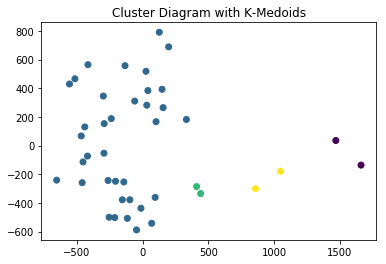

In [26]:
#plotting clusters formed via K-Medoids
pl.title('Cluster Diagram with K-Medoids')
pl.scatter(d_transformed[:, 0], d_transformed[:, 1], c = clusters)

<p> As we can see from the visual scatters above, the K-Medoids clustering differs quite a bit from the K-Means
clustering. In fact, on a visual comparison, the K-Medoids is quite similar in the clustering output to the clustering
output from Heirarchical clustering conducted in part C. </p>

<p> Conceptually, this difference in clustering makes sense. K-Medoids determines the centroids by minimizing absolute
distance between the points and the selected centroid rather than minimizing the squared distance. Additionally,
K-Medoids uses actual data points as the cluster centers whereas K-Means does not. These differences make K-Medoids
more robust to outliers in the data. When we look at the clusters and notice that the outlying points form their own clusters 
in the K-Medoids output, this approach comes to the fore. </p>